# Testing vaccinated and unvaccinated population outcomes

**Note:** Vaccination scenarios operate under the assumption that the delta variant is dominant.

In [46]:
import pandas as pd
import numpy as np
from os.path import join
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

from scseirx import analysis_functions as af

import data_creation_functions as dcf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

Vaccine effectiveness against Delta (see [Pouwels et al. 2021](https://www.ndm.ox.ac.uk/files/coronavirus/covid-19-infection-survey/finalfinalcombinedve20210816.pdf))
* 67% effectiveness against infection 14 days after second dose of Astra Zeneca (ChAdOx1)
* 80% effectiveness against infection 21 days after second dose of Biontech Pfizer (BNT162b2)
* Viral load of vaccinated infected people seems to be similar to unvaccinated infected people ([CDC 2021](https://www.cdc.gov/mmwr/volumes/70/wr/mm7031e2.htm)).
* Vaccine effectiveness seems to drop over time ([Pouwels et al. 2021](https://www.ndm.ox.ac.uk/files/coronavirus/covid-19-infection-survey/finalfinalcombinedve20210816.pdf)) (78% effectiveness against high viral load after 90 days for Biontech Pfizer and 61% effectiveness against high viral load after 90 days for Astra Zeneca). Go for 60% effectiveness against infection and 0% effectiveness against further gransmission to be conservative. 

## Simulation settings

In [48]:
with open('params/vaccinations_measures.json', 'r') as fp:
    measures = json.load(fp)
with open('params/vaccinations_simulation_parameters.json', 'r') as fp:
    simulation_params = json.load(fp)
with open('params/vaccinations_school_characteristics.json', 'r') as fp:
    school_characteristics = json.load(fp)

## Simulation function

In [49]:
def run(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters test_type, 
        index_case, e_screen_range and r_screen_range that are passed to the
        simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, ttype, s_screen_interval, t_screen_interval,\
        student_mask, teacher_mask, half_classes, ventilation_mod,\
        student_vaccination_ratio, teacher_vaccination_ratio = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, ttype, s_screen_interval, t_screen_interval,\
            student_mask, teacher_mask, half_classes, ventilation_mod,
             student_vaccination_ratio, teacher_vaccination_ratio)
    
    ensmbl_results['school_type'] = school_type
    ensmbl_results['index_case'] = index_case
    ensmbl_results['test_type'] = ttype
    ensmbl_results['student_screen_interval'] = s_screen_interval
    ensmbl_results['teacher_screen_interval'] = t_screen_interval
    ensmbl_results['student_mask'] = student_mask
    ensmbl_results['teacher_mask'] = teacher_mask
    ensmbl_results['half_classes'] = half_classes
    ensmbl_results['ventilation_mod'] = ventilation_mod
    ensmbl_results['student_vaccination_ratio'] = student_vaccination_ratio
    ensmbl_results['teacher_vaccination_ratio'] = teacher_vaccination_ratio
    
    return ensmbl_results

## Screening parameters

In [66]:
## parameter ranges 

# number of runs in the ensemble
# Note: this is set to 1 for testing purposes. To get properly converged 
# statistics, this has to be >= 500. Running such a high number of simulations
# will take a long time if run on just a single core. Therefore I strongly
# recommend to run the below code on several cores at once. It is easy to
# parallelize as each ensemble can be run on a different core and there are
# no interdependencies between ensembles. Results can be collected afterwards
# and evaulated together.
N_runs = 10
# different school types
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']
# specifies whether the index case will be introduced via an
# employee or a resident
index_cases = ['student', 'teacher']
# test technologies (and test result turnover times) used in the
# different scenarios
test_types = ['same_day_antigen']
# student and teacher streening intervals (in days)
s_screen_range = [None, 3, 7]
t_screen_range = [None, 3, 7]
# specifies whether teachers wear masks
student_masks = [True, False]
teacher_masks = [True, False]
half_classes = [True, False]
# specifies whether there is ventilation or not
transmission_risk_ventilation_modifiers = [1, 0.36]
# specifies the ratio of vaccinated students 
student_vaccination_ratios = [0.0, 0.5]
# specifies the ratio of vaccinated teachers
teacher_vaccination_ratios = [0.5]

params = [(N_runs, i, j, k, l, m, n, o, p, q, r, s)\
              for i in school_types \
              for j in index_cases \
              for k in test_types \
              for l in s_screen_range \
              for m in t_screen_range \
              for n in student_masks \
              for o in teacher_masks \
              for p in half_classes \
              for q in transmission_risk_ventilation_modifiers \
              for r in student_vaccination_ratios \
              for s in teacher_vaccination_ratios]

N_configs = len(params)
print('there are {} different parameter combinations'.format(N_configs))

there are 3456 different parameter combinations


In [62]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/vaccinations/testing'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run, iterable=params),
                           total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case', 'test_type',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'half_classes',
              'ventilation_mod', 'student_vaccination_ratio',
              'teacher_vaccination_ratio']
interesting_cols = ['index_case', 'student_vaccination_ratio', 
                    'teacher_vaccination_ratio']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[interesting_cols + other_cols]

results.to_csv(join(dst, 'vaccinations_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 18/18 [00:27<00:00,  1.55s/it]


CPU times: user 184 ms, sys: 107 ms, total: 292 ms
Wall time: 28 s


,index_case,student_vaccination_ratio,teacher_vaccination_ratio,N_diagnostic_tests,N_family_members,N_preventive_tests,N_school_agents,R0,diagnostic_test_detected_infections_family_member,diagnostic_test_detected_infections_student,...,run,seed,student_family_member_transmissions,student_student_transmissions,student_teacher_transmissions,teacher_student_transmissions,teacher_teacher_transmissions,tests_per_day_per_agent,transmissions,undetected_infections
0,student,0.5,1.0,6.0,346.0,0.0,164.0,3.0,2.0,4.0,...,1.0,1.0,12.0,8.0,2.0,5.0,0.0,0.000546,30.0,0.0
1,student,0.5,1.0,14.0,346.0,0.0,164.0,4.0,8.0,6.0,...,2.0,2.0,34.0,29.0,2.0,3.0,1.0,0.000805,81.0,0.0
2,student,0.5,1.0,1.0,346.0,0.0,164.0,1.0,0.0,1.0,...,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.000359,1.0,0.0


In [52]:
def set_vaccination_scenario(row):
    vaccination_scenario = 'student {:1.2f}\nteacher {:1.2f}'\
    .format(row['student_vaccination_ratio'], row['teacher_vaccination_ratio'])
    return vaccination_scenario

In [53]:
dst = '../../data/vaccinations/testing'
results = pd.read_csv(join(dst, 'vaccinations_{}.csv'.format(N_runs)))
results['vaccination_scenario'] = results.apply(set_vaccination_scenario, axis=1)

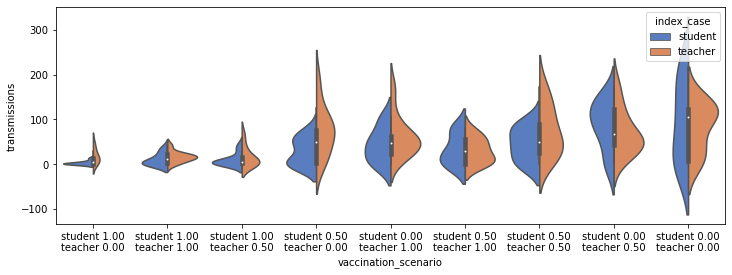

In [54]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.violinplot(x="vaccination_scenario", y="transmissions", hue="index_case",
                    data=results, palette="muted", split=True, ax=ax)
ax.tick_params(axis='x', labelsize=10)

## Aggregate results

In [58]:
from importlib import reload
reload(af)
reload(dcf)

<module 'data_creation_functions' from '/home/jana/Projects/COVID_schools/analysis/code/vaccinations/data_creation_functions.py'>

In [59]:
src = '../../data/vaccinations/testing'
for stype in school_types[0:1]:
    print(stype)
    data = dcf.get_data(stype, src)
    data['measure'] = np.nan
    dcf.set_individual_measures(data)
    dcf.set_measure_packages(data)
    #data.to_csv(join(dst, '{}_combined_ensembles.csv'.format(stype)), index=False)

primary


In [60]:
data.columns

Index(['N_diagnostic_tests', 'N_family_members', 'N_preventive_tests',
       'N_school_agents', 'R0',
       'diagnostic_test_detected_infections_family_member',
       'diagnostic_test_detected_infections_student',
       'diagnostic_test_detected_infections_teacher',
       'diagnostic_tests_per_day_per_agent', 'duration',
       'family_member_family_member_transmissions', 'infected_agents',
       'infected_family_members', 'infected_students', 'infected_teachers',
       'infected_without_transmissions', 'pending_test_infections',
       'predetected_infections',
       'preventive_test_detected_infections_family_member',
       'preventive_test_detected_infections_student',
       'preventive_test_detected_infections_teacher',
       'preventive_tests_per_day_per_agent', 'quarantine_days_family_member',
       'quarantine_days_student', 'quarantine_days_teacher', 'run', 'seed',
       'student_family_member_transmissions', 'student_student_transmissions',
       'student_teacher

In [63]:
data['measure']

0      no\nmeasure
1      no\nmeasure
2      no\nmeasure
3      no\nmeasure
4      no\nmeasure
          ...     
175    no\nmeasure
176    no\nmeasure
177    no\nmeasure
178    no\nmeasure
179    no\nmeasure
Name: measure, Length: 180, dtype: object